# Árvores de Decisão para Classificação

As árvores de decisão constituem um dos algoritmos fundamentais de aprendizado supervisionado, oferecendo uma abordagem interpretável e intuitiva para problemas de classificação. Este algoritmo constrói modelos preditivos através de estruturas hierárquicas que particionam recursivamente o espaço de características, criando regras de decisão claras e facilmente compreensíveis.

O estudo das árvores de decisão é fundamental para compreender tanto algoritmos simples quanto métodos ensemble mais complexos, formando a base teórica para técnicas como Random Forest e Gradient Boosting.


In [1]:
# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Configuração de plotting
plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (10, 6)

## Objetivos da Aula

- Compreender os fundamentos matemáticos das árvores de decisão
- Analisar os critérios de divisão: entropia, ganho de informação e índice de Gini
- Implementar árvores de decisão utilizando scikit-learn
- Dominar técnicas de visualização e interpretação de modelos
- Controlar overfitting através de hiperparâmetros de regularização
- Avaliar performance e limitações do algoritmo


In [ ]:
# Configuração do ambiente
import warnings

warnings.filterwarnings("ignore")

# Verificar se todas as bibliotecas estão disponíveis
print("Ambiente configurado com sucesso!")
print(f"NumPy versão: {np.__version__}")
print(f"Pandas versão: {pd.__version__}")
print(f"Matplotlib versão: {plt.matplotlib.__version__}")

Ambiente configurado com sucesso!
NumPy versão: 1.26.4
Pandas versão: 2.3.1
Matplotlib versão: 3.10.5


## 1. Fundamentos Teóricos

### 1.1 Definição Matemática

Uma árvore de decisão é uma estrutura hierárquica $T$ composta por:

- **Nós internos**: Representam testes em atributos $x_i$
- **Folhas**: Representam decisões ou classes $y$
- **Arestas**: Representam resultados dos testes

Formalmente, dado um conjunto de treinamento $D = \{(x^{(1)}, y^{(1)}), ..., (x^{(m)}, y^{(m)})\}$, onde $x^{(i)} \in \mathbb{R}^n$ e $y^{(i)} \in \{1, 2, ..., k\}$, uma árvore de decisão particiona recursivamente o espaço de características.

### 1.2 Critérios de Divisão

#### Entropia

A entropia de Shannon mede a impureza de um conjunto:

$$H(S) = -\sum_{i=1}^{k} p_i \log_2(p_i)$$

onde $p_i$ é a proporção de exemplos da classe $i$ no conjunto $S$.

#### Ganho de Informação

O ganho de informação ao dividir um conjunto $S$ usando o atributo $A$:

$$IG(S, A) = H(S) - \sum_{v \in Values(A)} \frac{|S_v|}{|S|} H(S_v)$$

#### Índice de Gini

Alternativa à entropia, mede a probabilidade de classificação incorreta:

$$Gini(S) = 1 - \sum_{i=1}^{k} p_i^2$$


In [ ]:
# Implementação dos critérios de divisão
def calcular_entropia(y):
    """
    Calcula a entropia de Shannon para um conjunto de labels.

    Parameters:
    y (array-like): Array de labels/classes

    Returns:
    float: Valor da entropia
    """
    classes, counts = np.unique(y, return_counts=True)
    probabilidades = counts / len(y)

    # Evitar log(0)
    probabilidades = probabilidades[probabilidades > 0]

    entropia = -np.sum(probabilidades * np.log2(probabilidades))
    return entropia


def calcular_gini(y):
    """
    Calcula o índice de Gini para um conjunto de labels.

    Parameters:
    y (array-like): Array de labels/classes

    Returns:
    float: Valor do índice de Gini
    """
    classes, counts = np.unique(y, return_counts=True)
    probabilidades = counts / len(y)

    gini = 1 - np.sum(probabilidades**2)
    return gini


def calcular_ganho_informacao(y_parent, y_left, y_right):
    """
    Calcula o ganho de informação de uma divisão.

    Parameters:
    y_parent (array-like): Labels do nó pai
    y_left (array-like): Labels do nó filho esquerdo
    y_right (array-like): Labels do nó filho direito

    Returns:
    float: Ganho de informação
    """
    n_parent = len(y_parent)
    n_left = len(y_left)
    n_right = len(y_right)

    entropia_parent = calcular_entropia(y_parent)
    entropia_weighted = (n_left / n_parent) * calcular_entropia(y_left) + (n_right / n_parent) * calcular_entropia(
        y_right
    )

    ganho = entropia_parent - entropia_weighted
    return ganho


# Exemplo prático dos cálculos
y_exemplo = np.array([0, 0, 1, 1, 1, 0, 1, 0, 1, 1])

print("Exemplo de cálculos:")
print(f"Dataset: {y_exemplo}")
print(f"Entropia: {calcular_entropia(y_exemplo):.4f}")
print(f"Índice de Gini: {calcular_gini(y_exemplo):.4f}")

# Exemplo de divisão
y_left = y_exemplo[:4]  # [0, 0, 1, 1]
y_right = y_exemplo[4:]  # [1, 0, 1, 0, 1, 1]

print(f"\nApós divisão:")
print(f"Esquerda: {y_left}")
print(f"Direita: {y_right}")
print(f"Ganho de informação: {calcular_ganho_informacao(y_exemplo, y_left, y_right):.4f}")

Exemplo de cálculos:
Dataset: [0 0 1 1 1 0 1 0 1 1]
Entropia: 0.9710
Índice de Gini: 0.4800

Após divisão:
Esquerda: [0 0 1 1]
Direita: [1 0 1 0 1 1]
Ganho de informação: 0.0200


## 2. Algoritmo de Construção

### 2.1 Algoritmo ID3 (Iterative Dichotomiser 3)

O algoritmo básico para construção de árvores de decisão segue uma abordagem recursiva:

**Entrada**: Conjunto de treinamento $D$, conjunto de atributos $A$
**Saída**: Árvore de decisão $T$

```
Função ConstruirÁrvore(D, A):
    Se todos os exemplos em D têm a mesma classe:
        Retornar folha com essa classe

    Se A está vazio:
        Retornar folha com classe majoritária em D

    Selecionar o melhor atributo A_best ∈ A baseado no critério de divisão

    Criar nó raiz para A_best

    Para cada valor v de A_best:
        D_v = subconjunto de D onde A_best = v

        Se D_v está vazio:
            Adicionar folha com classe majoritária em D
        Senão:
            Adicionar subárvore ConstruirÁrvore(D_v, A \ {A_best})

    Retornar árvore
```

### 2.2 Critérios de Parada

- **Pureza**: Todos os exemplos pertencem à mesma classe
- **Profundidade máxima**: Limite de níveis da árvore
- **Número mínimo de amostras**: Por nó ou folha
- **Ganho mínimo**: Threshold para divisões significativas


Tamanho do conjunto de treino: (700, 2)
Tamanho do conjunto de teste: (300, 2)
Distribuição de classes no treino: [351 349]
Distribuição de classes no teste: [150 150]


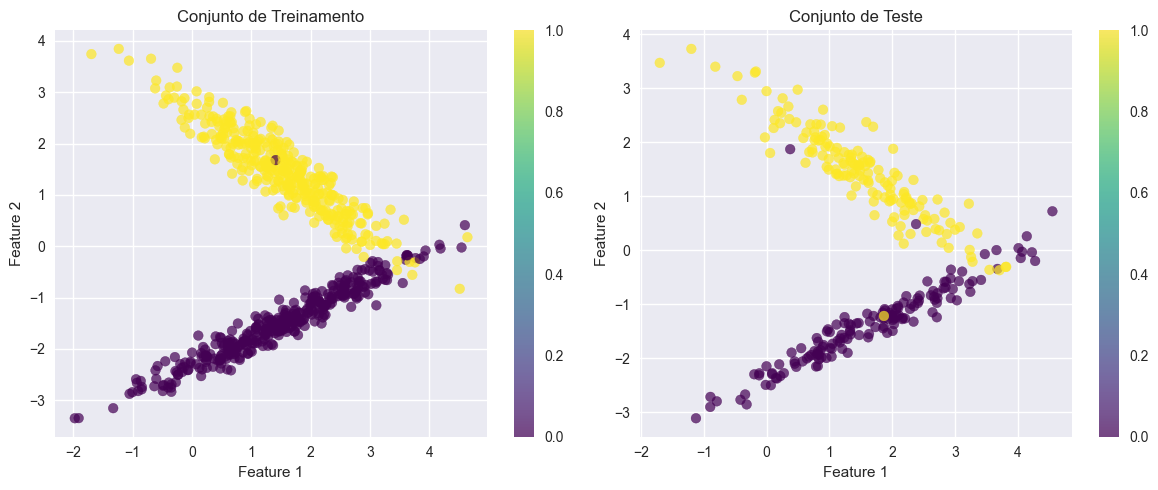

In [ ]:
# Geração de dataset sintético para demonstração
np.random.seed(42)

# Criar dataset de classificação binária
X, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    n_clusters_per_class=1,
    n_classes=2,
    class_sep=1.5,
    random_state=42,
)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Tamanho do conjunto de treino: {X_train.shape}")
print(f"Tamanho do conjunto de teste: {X_test.shape}")
print(f"Distribuição de classes no treino: {np.bincount(y_train)}")
print(f"Distribuição de classes no teste: {np.bincount(y_test)}")

# Visualizar o dataset
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="viridis", alpha=0.7)
plt.title("Conjunto de Treinamento")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter)

plt.subplot(1, 2, 2)
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="viridis", alpha=0.7)
plt.title("Conjunto de Teste")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.colorbar(scatter)

plt.tight_layout()
plt.show()

## 3. Implementação com Scikit-Learn

### 3.1 Modelo Básico



Gini:
  Acurácia Treino: 1.0000
  Acurácia Teste: 0.9567
  Profundidade: 10
  Número de folhas: 17

Entropia:
  Acurácia Treino: 1.0000
  Acurácia Teste: 0.9567
  Profundidade: 12
  Número de folhas: 18

Log Loss:
  Acurácia Treino: 1.0000
  Acurácia Teste: 0.9567
  Profundidade: 12
  Número de folhas: 18


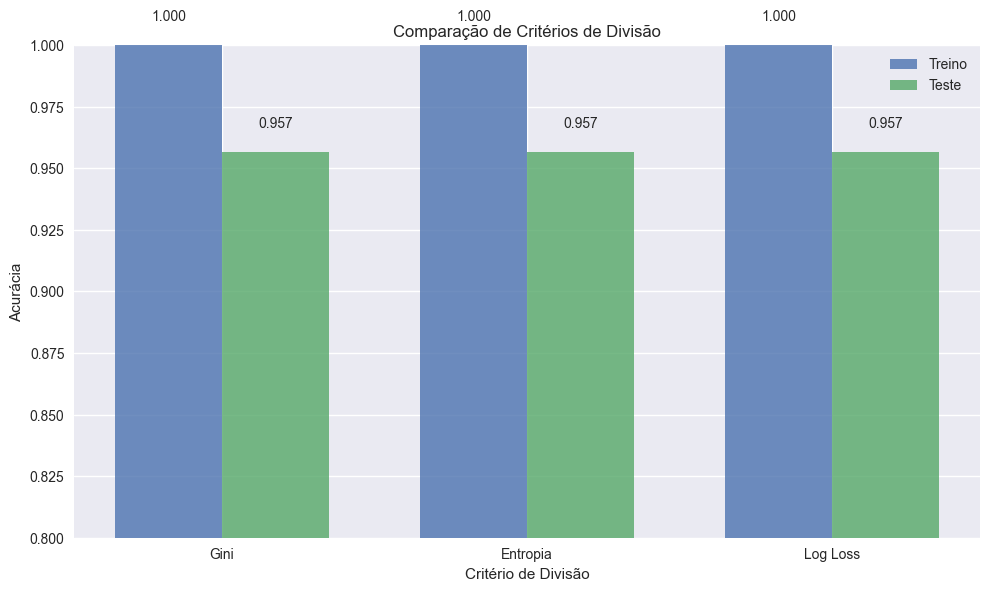

In [ ]:
# Criar árvores de decisão com diferentes critérios
modelos = {
    "Gini": DecisionTreeClassifier(criterion="gini", random_state=42),
    "Entropia": DecisionTreeClassifier(criterion="entropy", random_state=42),
    "Log Loss": DecisionTreeClassifier(criterion="log_loss", random_state=42),
}

# Treinar e avaliar cada modelo
resultados = {}

for nome, modelo in modelos.items():
    # Treinar o modelo
    modelo.fit(X_train, y_train)

    # Fazer predições
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    # Calcular acurácias
    acc_train = np.mean(y_pred_train == y_train)
    acc_test = np.mean(y_pred_test == y_test)

    resultados[nome] = {
        "modelo": modelo,
        "acc_train": acc_train,
        "acc_test": acc_test,
        "profundidade": modelo.get_depth(),
        "n_folhas": modelo.get_n_leaves(),
    }

    print(f"\n{nome}:")
    print(f"  Acurácia Treino: {acc_train:.4f}")
    print(f"  Acurácia Teste: {acc_test:.4f}")
    print(f"  Profundidade: {modelo.get_depth()}")
    print(f"  Número de folhas: {modelo.get_n_leaves()}")

# Comparação visual dos resultados
criterios = list(resultados.keys())
acc_train_vals = [resultados[c]["acc_train"] for c in criterios]
acc_test_vals = [resultados[c]["acc_test"] for c in criterios]

x = np.arange(len(criterios))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width / 2, acc_train_vals, width, label="Treino", alpha=0.8)
plt.bar(x + width / 2, acc_test_vals, width, label="Teste", alpha=0.8)

plt.xlabel("Critério de Divisão")
plt.ylabel("Acurácia")
plt.title("Comparação de Critérios de Divisão")
plt.xticks(x, criterios)
plt.legend()
plt.ylim(0.8, 1.0)

for i, (train, test) in enumerate(zip(acc_train_vals, acc_test_vals)):
    plt.text(i - width / 2, train + 0.01, f"{train:.3f}", ha="center")
    plt.text(i + width / 2, test + 0.01, f"{test:.3f}", ha="center")

plt.tight_layout()
plt.show()

### 3.2 Visualização da Árvore de Decisão


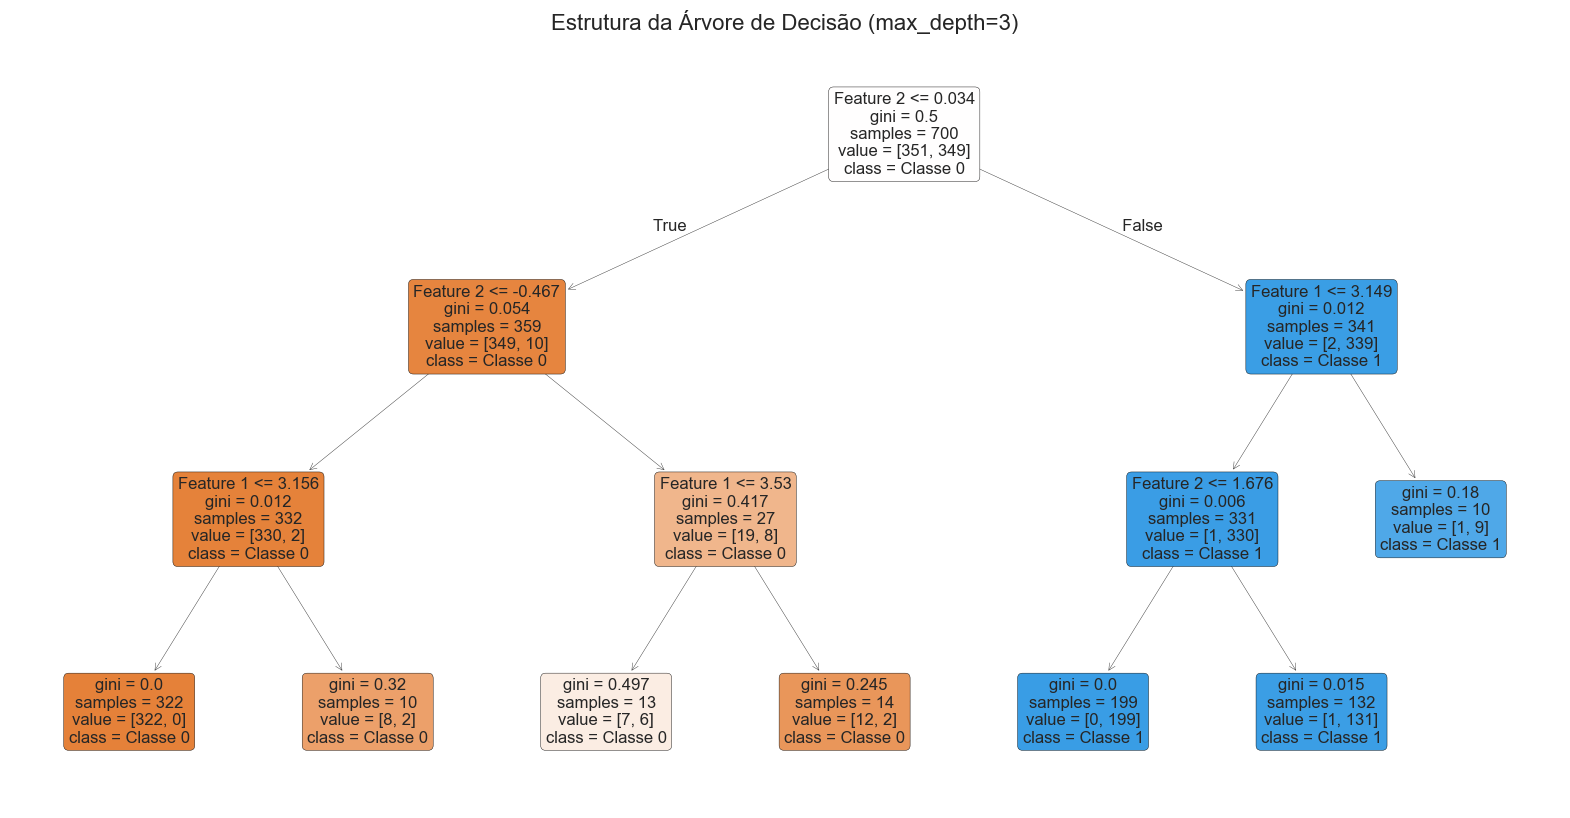

Profundidade da árvore: 3
Número de folhas: 7
Acurácia no treino: 0.9829
Acurácia no teste: 0.9567


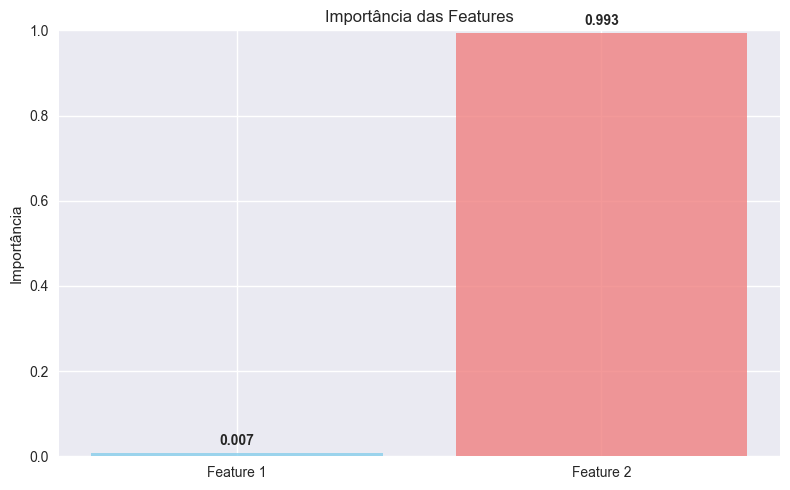

In [ ]:
# Criar uma árvore mais simples para visualização
modelo_simples = DecisionTreeClassifier(
    criterion="gini",
    max_depth=3,  # Limitar profundidade para melhor visualização
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42,
)

modelo_simples.fit(X_train, y_train)

# Visualizar a estrutura da árvore
plt.figure(figsize=(20, 10))
plot_tree(
    modelo_simples,
    feature_names=["Feature 1", "Feature 2"],
    class_names=["Classe 0", "Classe 1"],
    filled=True,
    rounded=True,
    fontsize=12,
)
plt.title("Estrutura da Árvore de Decisão (max_depth=3)", fontsize=16)
plt.show()

print(f"Profundidade da árvore: {modelo_simples.get_depth()}")
print(f"Número de folhas: {modelo_simples.get_n_leaves()}")
print(f"Acurácia no treino: {modelo_simples.score(X_train, y_train):.4f}")
print(f"Acurácia no teste: {modelo_simples.score(X_test, y_test):.4f}")

# Importância das features
importancias = modelo_simples.feature_importances_
features = ["Feature 1", "Feature 2"]

plt.figure(figsize=(8, 5))
plt.bar(features, importancias, alpha=0.8, color=["skyblue", "lightcoral"])
plt.title("Importância das Features")
plt.ylabel("Importância")
plt.ylim(0, 1)

for i, imp in enumerate(importancias):
    plt.text(i, imp + 0.02, f"{imp:.3f}", ha="center", fontweight="bold")

plt.tight_layout()
plt.show()

### 3.3 Fronteiras de Decisão


In [ ]:
# Função para plotar fronteiras de decisão
def plot_decision_boundary(modelo, X, y, title):
    """
    Plota as fronteiras de decisão de um modelo de classificação.
    """
    h = 0.02  # Tamanho do passo no mesh

    # Criar mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predições para o mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = modelo.predict(mesh_points)
    Z = Z.reshape(xx.shape)

    # Plotar
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors="black")
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    return scatter


# Comparar fronteiras de decisão com diferentes profundidades
profundidades = [2, 3, 5, None]

plt.figure(figsize=(16, 12))

for i, depth in enumerate(profundidades):
    plt.subplot(2, 2, i + 1)

    # Treinar modelo com profundidade específica
    modelo_depth = DecisionTreeClassifier(criterion="gini", max_depth=depth, random_state=42)
    modelo_depth.fit(X_train, y_train)

    # Plotar fronteira
    title = f"max_depth={depth}" if depth else "max_depth=None (sem limite)"
    scatter = plot_decision_boundary(modelo_depth, X_train, y_train, title)

    # Adicionar informações do modelo
    acc_train = modelo_depth.score(X_train, y_train)
    acc_test = modelo_depth.score(X_test, y_test)
    plt.text(
        0.02,
        0.98,
        f"Train Acc: {acc_train:.3f}\\nTest Acc: {acc_test:.3f}",
        transform=plt.gca().transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
    )

plt.tight_layout()
plt.show()

## 4. Controle de Overfitting

### 4.1 Hiperparâmetros de Regularização

As árvores de decisão são propensas ao overfitting quando crescem sem restrições. Os principais hiperparâmetros para controle são:

- **max_depth**: Profundidade máxima da árvore
- **min_samples_split**: Número mínimo de amostras para dividir um nó
- **min_samples_leaf**: Número mínimo de amostras em uma folha
- **max_features**: Número máximo de features consideradas em cada divisão
- **min_impurity_decrease**: Diminuição mínima da impureza para realizar divisão


In [ ]:
# Análise do efeito da profundidade no overfitting
profundidades = range(1, 21)
acc_train_list = []
acc_test_list = []

for depth in profundidades:
    modelo = DecisionTreeClassifier(max_depth=depth, random_state=42)
    modelo.fit(X_train, y_train)

    acc_train = modelo.score(X_train, y_train)
    acc_test = modelo.score(X_test, y_test)

    acc_train_list.append(acc_train)
    acc_test_list.append(acc_test)

# Plotar curvas de learning
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(profundidades, acc_train_list, "o-", label="Treino", linewidth=2)
plt.plot(profundidades, acc_test_list, "s-", label="Teste", linewidth=2)
plt.xlabel("Profundidade Máxima")
plt.ylabel("Acurácia")
plt.title("Efeito da Profundidade na Acurácia")
plt.legend()
plt.grid(True, alpha=0.3)

# Encontrar a profundidade ótima
gap = np.array(acc_train_list) - np.array(acc_test_list)
optimal_depth = profundidades[np.argmin(gap)]
plt.axvline(x=optimal_depth, color="red", linestyle="--", alpha=0.7, label=f"Profundidade ótima: {optimal_depth}")
plt.legend()

# Plotar o gap entre treino e teste
plt.subplot(1, 2, 2)
plt.plot(profundidades, gap, "ro-", linewidth=2)
plt.xlabel("Profundidade Máxima")
plt.ylabel("Gap (Treino - Teste)")
plt.title("Indicador de Overfitting")
plt.grid(True, alpha=0.3)
plt.axhline(y=0.05, color="orange", linestyle="--", alpha=0.7, label="Threshold (5%)")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Profundidade com menor gap: {optimal_depth}")
print(f"Gap mínimo: {gap[optimal_depth-1]:.4f}")

# Testar diferentes combinações de hiperparâmetros
configs = [
    {"name": "Sem restrições", "params": {}},
    {"name": "max_depth=5", "params": {"max_depth": 5}},
    {"name": "min_samples_split=50", "params": {"min_samples_split": 50}},
    {"name": "min_samples_leaf=20", "params": {"min_samples_leaf": 20}},
    {"name": "Combinado", "params": {"max_depth": 5, "min_samples_split": 20, "min_samples_leaf": 10}},
]

print("\n" + "=" * 60)
print("Comparação de Configurações de Hiperparâmetros")
print("=" * 60)

for config in configs:
    modelo = DecisionTreeClassifier(random_state=42, **config["params"])
    modelo.fit(X_train, y_train)

    acc_train = modelo.score(X_train, y_train)
    acc_test = modelo.score(X_test, y_test)
    gap = acc_train - acc_test

    print(f"\n{config['name']}:")
    print(f"  Acurácia Treino: {acc_train:.4f}")
    print(f"  Acurácia Teste:  {acc_test:.4f}")
    print(f"  Gap:             {gap:.4f}")
    print(f"  Profundidade:    {modelo.get_depth()}")
    print(f"  Nº Folhas:       {modelo.get_n_leaves()}")

## 5. Avaliação e Interpretação


In [ ]:
# Treinar modelo final com hiperparâmetros otimizados
modelo_final = DecisionTreeClassifier(
    criterion="gini", max_depth=5, min_samples_split=20, min_samples_leaf=10, random_state=42
)

modelo_final.fit(X_train, y_train)

# Predições
y_pred_train = modelo_final.predict(X_train)
y_pred_test = modelo_final.predict(X_test)

# Relatório de classificação
print("Relatório de Classificação - Conjunto de Teste:")
print("=" * 50)
print(classification_report(y_test, y_pred_test, target_names=["Classe 0", "Classe 1"]))

# Matriz de confusão
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de confusão - Treino
cm_train = confusion_matrix(y_train, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["Classe 0", "Classe 1"])
disp_train.plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title("Matriz de Confusão - Treino")

# Matriz de confusão - Teste
cm_test = confusion_matrix(y_test, y_pred_test)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Classe 0", "Classe 1"])
disp_test.plot(ax=axes[1], cmap="Blues", values_format="d")
axes[1].set_title("Matriz de Confusão - Teste")

plt.tight_layout()
plt.show()

# Calcular métricas detalhadas
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

metricas = {
    "Acurácia": modelo_final.score(X_test, y_test),
    "Precisão": precision_score(y_test, y_pred_test),
    "Recall": recall_score(y_test, y_pred_test),
    "F1-Score": f1_score(y_test, y_pred_test),
}

# Probabilidades para ROC-AUC
y_proba_test = modelo_final.predict_proba(X_test)[:, 1]
metricas["ROC-AUC"] = roc_auc_score(y_test, y_proba_test)

print("\nMétricas de Avaliação:")
print("=" * 25)
for metrica, valor in metricas.items():
    print(f"{metrica:10}: {valor:.4f}")

# Análise da importância das features
importancias = modelo_final.feature_importances_
features = ["Feature 1", "Feature 2"]

print(f"\nImportância das Features:")
print("=" * 25)
for i, (feature, imp) in enumerate(zip(features, importancias)):
    print(f"{feature}: {imp:.4f}")

# Análise de exemplos mal classificados
erros_idx = np.where(y_test != y_pred_test)[0]
print(f"\nExemplos mal classificados: {len(erros_idx)} de {len(y_test)} ({len(erros_idx)/len(y_test)*100:.1f}%)")

if len(erros_idx) > 0:
    plt.figure(figsize=(10, 6))

    # Plotar todos os pontos
    scatter_all = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="viridis", alpha=0.6, s=50, label="Corretos")

    # Destacar erros
    plt.scatter(X_test[erros_idx, 0], X_test[erros_idx, 1], c="red", s=100, marker="x", linewidth=3, label="Erros")

    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Análise de Exemplos Mal Classificados")
    plt.legend()
    plt.colorbar(scatter_all, label="Classe Verdadeira")
    plt.show()

## 6. Vantagens e Limitações

### 6.1 Vantagens das Árvores de Decisão

1. **Interpretabilidade**: Estrutura clara e facilmente compreensível
2. **Não requer preparação de dados**: Lida bem com features categóricas e numéricas
3. **Seleção automática de features**: Considera apenas features relevantes
4. **Robustez a outliers**: Divisões baseadas em ordenação, não em valores absolutos
5. **Versatilidade**: Aplicável a problemas de classificação e regressão

### 6.2 Limitações

1. **Instabilidade**: Pequenas mudanças nos dados podem resultar em árvores muito diferentes
2. **Overfitting**: Tendência a memorizar o conjunto de treinamento
3. **Viés para features com mais valores**: Features categóricas com muitas categorias são favorecidas
4. **Dificuldade com relações lineares**: Não captura bem relações lineares simples
5. **Fronteiras de decisão ortogonais**: Limitadas a divisões paralelas aos eixos

### 6.3 Complexidade Computacional

- **Treinamento**: $O(n \log n \cdot d)$ onde $n$ é o número de amostras e $d$ o número de features
- **Predição**: $O(\log n)$ no caso médio, $O(n)$ no pior caso
- **Espaço**: $O(n)$ para armazenar a árvore


In [ ]:
# Demonstração da instabilidade das árvores de decisão
np.random.seed(42)

# Criar duas versões do dataset com pequenas variações
X_v1 = X_train.copy()
X_v2 = X_train + np.random.normal(0, 0.05, X_train.shape)  # Pequeno ruído

# Treinar modelos idênticos nos dois datasets
modelo_v1 = DecisionTreeClassifier(max_depth=6, random_state=42)
modelo_v2 = DecisionTreeClassifier(max_depth=6, random_state=42)

modelo_v1.fit(X_v1, y_train)
modelo_v2.fit(X_v2, y_train)

# Comparar as predições
pred_v1 = modelo_v1.predict(X_test)
pred_v2 = modelo_v2.predict(X_test)

# Calcular similaridade das predições
agreement = np.mean(pred_v1 == pred_v2)
print(f"Concordância entre modelos em datasets ligeiramente diferentes: {agreement:.3f}")
print(f"Isso demonstra a instabilidade inerente das árvores de decisão")

# Demonstração da dificuldade com relações lineares
np.random.seed(42)

# Criar dataset com relação linear simples
X_linear = np.random.uniform(-2, 2, (500, 2))
y_linear = (X_linear[:, 0] + X_linear[:, 1] > 0).astype(int)  # Linha diagonal

# Dividir em treino e teste
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X_linear, y_linear, test_size=0.3, random_state=42)

# Treinar árvore de decisão
modelo_linear = DecisionTreeClassifier(max_depth=5, random_state=42)
modelo_linear.fit(X_train_lin, y_train_lin)

# Visualizar o resultado
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train_lin[:, 0], X_train_lin[:, 1], c=y_train_lin, cmap="RdBu", alpha=0.7)
plt.plot([-2, 2], [2, -2], "k--", linewidth=2, label="Fronteira verdadeira")
plt.title("Problema Linear Simples")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.subplot(1, 2, 2)
plot_decision_boundary(modelo_linear, X_train_lin, y_train_lin, "Solução da Árvore de Decisão")

acc_linear = modelo_linear.score(X_test_lin, y_test_lin)
plt.text(
    0.02,
    0.98,
    f"Acurácia: {acc_linear:.3f}",
    transform=plt.gca().transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
)

plt.tight_layout()
plt.show()

print(f"\nAcurácia no problema linear: {acc_linear:.3f}")
print("Note como a árvore tem dificuldade com a fronteira diagonal simples")
print(f"Profundidade necessária: {modelo_linear.get_depth()}")
print(f"Número de folhas: {modelo_linear.get_n_leaves()}")

## Resumo

Nesta aula, estudamos as árvores de decisão, um dos algoritmos fundamentais de machine learning para classificação. Os principais conceitos abordados incluem:

**Fundamentos Teóricos:**

- Critérios de divisão: entropia, ganho de informação e índice de Gini
- Algoritmo de construção recursiva (ID3)
- Complexidade computacional e critérios de parada

**Implementação Prática:**

- Utilização do scikit-learn para diferentes critérios
- Visualização da estrutura da árvore e fronteiras de decisão
- Interpretação da importância das features

**Controle de Overfitting:**

- Hiperparâmetros de regularização (max_depth, min_samples_split, etc.)
- Análise do trade-off entre complexidade e generalização
- Técnicas de poda para melhorar a performance

**Avaliação e Limitações:**

- Métricas de classificação e análise de erros
- Vantagens: interpretabilidade, robustez, versatilidade
- Limitações: instabilidade, overfitting, dificuldade com relações lineares

As árvores de decisão formam a base para algoritmos ensemble mais avançados e são essenciais para compreender métodos como Random Forest e Gradient Boosting.

## Próximos Conteúdos

- **01_intro_classificacao.ipynb**: Introdução aos conceitos fundamentais de classificação
- **02_knn.ipynb**: Algoritmo K-Nearest Neighbors para classificação
